In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# Read in Small Data (metadata)

In [2]:
metadata = pd.read_csv('big_data/metadata.csv')
metadata = metadata[pd.isnull(metadata['abstract']) == False].reset_index(drop=True)

Using the search query to focus on abstracts:
"COVID-19" OR Coronavirus OR "Corona virus" OR "2019-nCoV" OR "SARS-CoV" OR "MERS-CoV" OR “Severe Acute Respiratory Syndrome” OR “Middle East Respiratory Syndrome” 

In [3]:
 metadata = metadata[metadata['abstract'].str.lower().str.contains(
     "covid-19|coronavirus|coronavirus|corona virus|2019-ncov|sars-cov|mers-cov|severe acute respiratory syndrome|middle east respiratory syndrome") | 
         metadata['abstract'].str.contains("MERS")
         ]

In [4]:
count = sum(metadata['abstract'].str.contains('COVID'))
print('There are ' + str(count) + ' articles mentioning COVID, which likely refers to COVID-19.')

count = sum(metadata['abstract'].str.contains('COVID-19'))
print('There are ' + str(count) + ' articles mentioning COVID-19.')

count = sum(metadata['abstract'].str.contains('COVID-19')[(pd.isnull(metadata['abstract']) == False) & 
                                                          (metadata['abstract'].str.contains('COVID-19'))
                                                         ] 
           )
print('There are ' + str(count) + ' articles mentioning COVID and COVID-19.')

There are 899 articles mentioning COVID, which likely refers to COVID-19.
There are 881 articles mentioning COVID-19.
There are 881 articles mentioning COVID and COVID-19.


In [5]:
covid_article_indexes = np.argwhere(metadata['abstract'].str.contains('COVID')).T[0]

C:\Users\vldoa\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


# SciBERT Implementation

In [6]:
# from transformers import *

# tokenizer = AutoTokenizer.from_pretrained('big_data/allenai/scibert_scivocab_uncased')
# model = AutoModel.from_pretrained('big_data/allenai/scibert_scivocab_uncased')

# Traditional ML

## Preprocessing

In [7]:
# metadata['abstract_processed'] = metadata['abstract'].str.lower()
# metadata["abstract_processed"] = metadata['abstract_processed'].str.replace('[^\w\s]','')

In [8]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import nltk
# nltk.download('wordnet')
from nltk.corpus import wordnet

stemmer = SnowballStemmer('english')

In [9]:
# function to perform lemmatize and stem preprocessing steps on the data set.

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [10]:
t = time.time()
metadata['gensim_abstract_processed'] = metadata['abstract'].map(preprocess)
print(time.time() - t)

51.05390119552612


Remove additional stop words

In [11]:
stop = ['abstract']
metadata['gensim_abstract_processed'] = metadata['gensim_abstract_processed'].apply(
    lambda x: [item for item in x if item not in stop])

Create a dictionary for word counts

In [12]:
dictionary = gensim.corpora.Dictionary(metadata['gensim_abstract_processed'])
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break
print(str(len(dictionary)) + ' unique words')

0 canin
1 common
2 competit
3 coronavirus
4 describ
5 direct
6 elisa
7 epitop
8 felin
9 peplom
10 prcv
21241 unique words


In [13]:
# Select which words in the dict to keep
dictionary.filter_extremes(no_below=2,
                           #no_above=0.5, 
                           #keep_n=100000
                          )
print(str(len(dictionary)) + ' unique words')

10326 unique words


In [14]:
# Create corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in metadata['gensim_abstract_processed']]

# Preview the corpus
bow_doc_4310 = bow_corpus[100]
for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                               dictionary[bow_doc_4310[i][0]], 
bow_doc_4310[i][1]))

Word 14 ("abort") appears 3 time.
Word 20 ("clinic") appears 2 time.
Word 22 ("current") appears 1 time.
Word 23 ("detect") appears 3 time.
Word 24 ("diseas") appears 1 time.
Word 33 ("immun") appears 1 time.
Word 34 ("import") appears 1 time.
Word 38 ("lead") appears 1 time.
Word 45 ("pregnant") appears 2 time.
Word 51 ("sever") appears 2 time.
Word 53 ("sign") appears 3 time.
Word 62 ("viral") appears 2 time.
Word 107 ("investig") appears 1 time.
Word 108 ("later") appears 1 time.
Word 110 ("like") appears 2 time.
Word 114 ("main") appears 1 time.
Word 123 ("occur") appears 1 time.
Word 167 ("establish") appears 1 time.
Word 182 ("observ") appears 2 time.
Word 189 ("rectal") appears 2 time.
Word 221 ("includ") appears 1 time.
Word 269 ("group") appears 2 time.
Word 300 ("begin") appears 3 time.
Word 304 ("control") appears 1 time.
Word 305 ("daili") appears 1 time.
Word 306 ("day") appears 3 time.
Word 333 ("normal") appears 2 time.
Word 336 ("persist") appears 1 time.
Word 337 ("pha

In [15]:
# Creating tf-idf matrix from bow (not clear if needed)

from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.2878179722531886),
 (1, 0.16374946126623613),
 (2, 0.36657642137743807),
 (3, 0.20646168756281605),
 (4, 0.1856547237513892),
 (5, 0.2702570305821325),
 (6, 0.2570528638531498),
 (7, 0.24718494055146684),
 (8, 0.41483276442170336),
 (9, 0.3799652464924452),
 (10, 0.08995644641575871),
 (11, 0.1333188927378907),
 (12, 0.26778929785167555),
 (13, 0.2542087931696541)]


## PCA

## Implementation

In [16]:
# .T to transpose since it's a word-doc matrix, not doc-word matrix
tfidf_sparse = gensim.matutils.corpus2csc(corpus_tfidf, printprogress=500).T

In [17]:
from sklearn.preprocessing import normalize
tfidf_sparse_norm = normalize(tfidf_sparse, norm='l1', axis=1)

(0, 1.01)

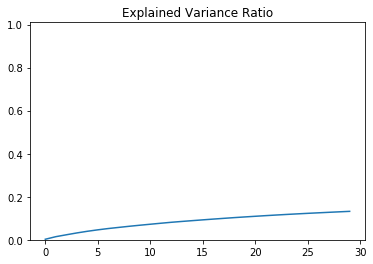

In [42]:
truncatedsvd = TruncatedSVD(n_components = 30, algorithm = 'randomized', random_state = 20)

transformed = truncatedsvd.fit_transform(tfidf_sparse_norm)

plt.title('Explained Variance Ratio')
plt.plot(np.cumsum(truncatedsvd.explained_variance_ratio_)[0:30])
plt.ylim(0, 1.01)

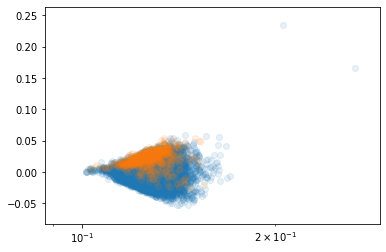

In [40]:
xscale_log_addition = 0.1

not_covid = (np.isin(np.array(list(range(len(transformed)))), covid_article_indexes) == False)
plt.scatter(transformed[not_covid,0] + xscale_log_addition,
            transformed[not_covid,1], alpha=0.1)

plt.scatter(transformed[covid_article_indexes,0] + xscale_log_addition,
            transformed[covid_article_indexes,1], alpha=0.1)
# plt.yscale('log')
plt.xscale('log')

<IPython.core.display.Javascript object>


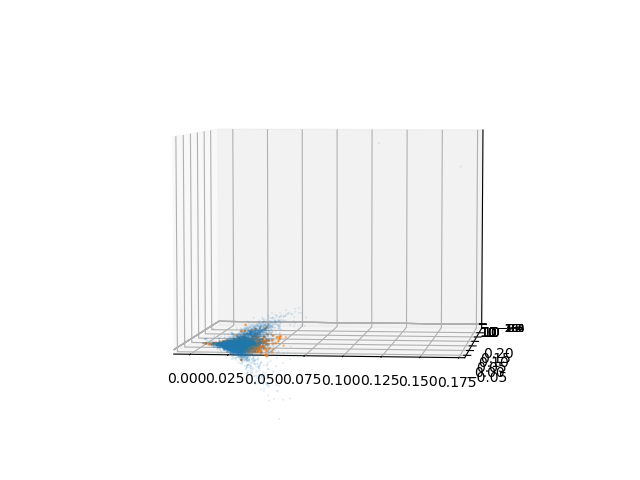

In [59]:
%matplotlib notebook



import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(transformed[not_covid,0], transformed[not_covid,1], transformed[not_covid,2], s=0.1, alpha=0.2)
ax.scatter(transformed[covid_article_indexes,0], transformed[covid_article_indexes,1],
           transformed[covid_article_indexes,2], s=1)

# ax.xscale('log')
ax.set_zscale('log')
# ax.set_yscale('log')

## Analysis

In [34]:
c = 1

word_ids_sorted = np.argsort(np.abs(truncatedsvd.components_[c]))[::-1]
top_words = [[dictionary[word_ids_sorted[i]], truncatedsvd.components_[c, word_ids_sorted[i]]] for i in range(100)]
top_words = pd.DataFrame(top_words, columns=['word', 'component_score'])
top_words = top_words.sort_values('component_score')

In [38]:
np.array(top_words).tolist()

[['protein', -0.28177114718807916],
 ['cell', -0.18375296982095543],
 ['bind', -0.11398543920042525],
 ['express', -0.10226705522446243],
 ['domain', -0.09188165463170418],
 ['structur', -0.09077284787794365],
 ['activ', -0.08998122368449789],
 ['replic', -0.08976305152898295],
 ['membran', -0.08707410400027288],
 ['gene', -0.08603611686040709],
 ['fusion', -0.08431829148241222],
 ['receptor', -0.08431078226564798],
 ['tgev', -0.08021574434290005],
 ['spike', -0.07796337537709759],
 ['interact', -0.07367365358211189],
 ['sequenc', -0.07226967304761148],
 ['induc', -0.06989781546339305],
 ['peptid', -0.06661373165296182],
 ['strain', -0.06605884063809445],
 ['recombin', -0.064498717605551],
 ['amino', -0.0638527252147544],
 ['antibodi', -0.06337334207808891],
 ['inhibit', -0.061616460547618865],
 ['genom', -0.06115076961354868],
 ['termin', -0.05968420518989212],
 ['immun', -0.05897078618508184],
 ['residu', -0.0577253556872168],
 ['sar', -0.05672721368394418],
 ['host', -0.056244917777

In [21]:
metadata['component_0'] = transformed[:,0] * 10**6
metadata['component_1'] = transformed[:,1] * 10**6

metadata['component_0_percentile'] = metadata['component_0'].rank(pct=True)
metadata['component_1_percentile'] = metadata['component_1'].rank(pct=True)

In [22]:
metadata['abstract_COVID'] = metadata['abstract'].str.contains('COVID')

In [23]:
metadata.columns

Index(['sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id', 'license',
       'abstract', 'publish_time', 'authors', 'journal',
       'Microsoft Academic Paper ID', 'WHO #Covidence', 'has_full_text',
       'full_text_file', 'gensim_abstract_processed', 'component_0',
       'component_1', 'component_0_percentile', 'component_1_percentile',
       'abstract_COVID'],
      dtype='object')

In [26]:
metadata_small = metadata[[
    'title', 'doi', 'pmcid', 'pubmed_id', 'abstract', 'publish_time', 'journal', 
    
    'component_0', 'component_1', 'component_0_percentile', 'component_1_percentile', 'abstract_COVID'
]]
metadata_small.to_csv('big_data/metadata_PCAed_subsetted.csv', sep='|', index=False)

In [25]:
metadata_small

,title,doi,pmcid,pubmed_id,abstract,publish_time,journal,component_0,component_1,component_0_percentile,component_1_percentile,abstract_COVID
27,An ELISA for the detection of serum antibodies...,10.1016/0007-1935(91)90010-K,NaN,1717102.0,Abstract A competition ELISA utilizing a mAb d...,1991-08-31,British Veterinary Journal,28078.244875,-25991.317997,0.629795,0.070029,False
29,Equine arteritis virus: An overview,10.1016/0007-1935(92)90044-2,NaN,1319787.0,Abstract The causative agent of the respirator...,1992-06-30,British Veterinary Journal,16745.907037,-1347.118295,0.090674,0.485630,False
33,Morphology and morphogenesis of a coronavirus ...,10.1016/0014-4800(76)90045-9,NaN,187445.0,Abstract The morphology and morphogenesis of v...,1976-12-31,Experimental and Molecular Pathology,13009.131458,-10803.307786,0.027683,0.329032,False
37,Bovine coronavirus antigen in the host cell pl...,10.1016/0014-4800(90)90039-G,NaN,2261945.0,Abstract Expression of bovine coronavirus (BCV...,1990-10-31,Experimental and Molecular Pathology,24166.605906,-22515.423680,0.422287,0.118827,False
44,Endosomal association of a protein phosphatase...,10.1016/0014-5793(91)80528-B,NaN,1674698.0,Abstract On the assumption that dephosphorylat...,1991-05-06,FEBS Letters,15406.657609,-13085.320712,0.061466,0.289150,False
45,Putative papain-related thiol proteases of pos...,10.1016/0014-5793(91)81034-6,NaN,1652473.0,Abstract A computer-assisted comparative analy...,1991-08-19,FEBS Letters,27325.691087,-23172.722637,0.592962,0.107801,False
51,Influence of coronavirus (transmissible gastro...,10.1016/0016-5085(84)90717-0,NaN,6735081.0,Abstract Four silver—silver chloride electrode...,1984-08-31,Gastroenterology,12194.055505,-780.353176,0.021701,0.495249,False
57,An in-depth study of Crohn's disease in two Fr...,10.1016/0016-5085(93)90401-W,NaN,8425677.0,Abstract Background: Two French families were ...,1993-02-28,Gastroenterology,17792.343482,4961.152465,0.120000,0.591202,False
67,The pathogenesis of nephritis in chickens indu...,10.1016/0021-9975(82)90078-0,NaN,6282945.0,Abstract Nephritis in chickens caused by infec...,1982-04-30,Journal of Comparative Pathology,12416.720750,-4927.540206,0.023226,0.425806,False
76,Pathogenicity and antigen detection of the Nou...,10.1016/0021-9975(92)90068-6,NaN,1313460.0,Abstract We compared the pathogenicity and the...,1992-01-31,Journal of Comparative Pathology,14596.154901,-6387.774775,0.046217,0.404106,False


## Clustering